In [1]:
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict
import re
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function Definitions
def queryit(cursor, query): 
    cursor.execute(query)
    return cursor.fetchall()

def calculate_frequency(models_per_task):
    frequency_data = {}
    for task, timestamps in models_per_task.items():
        frequency = {}
        for timestamp in timestamps:
            year_month = timestamp[:7]  # Extract Year-Month
            frequency[year_month] = frequency.get(year_month, 0) + 1
        frequency_data[task] = frequency
    return frequency_data

def parse_single_file(url):
    response = requests.get(url)
    return response.content.decode("utf-8")

def extract_params(returned): 
    match = re.search(r'">(.*?) params<', returned)
    return match.group(1) if match else None

def replace_tag(row_dict, tag_to_domain): 
    for repo_url in row_dict:
        row_dict[repo_url]['domain.name'] = None
        for domain in tag_to_domain: 
            if row_dict[repo_url]['tag.name'] in tag_to_domain[domain]: 
                row_dict[repo_url]['domain.name'] = domain

def mil_bil(x):
    try:  
        if 'M' in x: 
            return 1000000 * float(re.sub('(M)', '', x))
        elif 'B' in x: 
            return 1000000000 * float(re.sub('(B)', '', x))
        else: 
            return 0
    except ValueError: 
        return 0 

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

def to_9month_interval(date):
    year, month = date.year, date.month
    if month <= 9: 
        return f"{year}-01 to {year}-09"
    else: 
        return f"{year}-10 to {year + 1}-06"

In [2]:
# Constants and global variables
hf_domains  = {
    'Multimodal': ['feature-extraction', 'text-to-image', 'image-to-text', 'text-to-video', 'visual-question-answering', 'graph-machine-learning'],
    'Computer Vision': ['depth-estimation', 'image-classification', 'object-detection', 'image-segmentation', 'image-to-image', 'unconditional-image-generation', 'video-classification', 'zero-shot-image-classification'],
    'NLP': ['text-classification', 'token-classification', 'table-question-answering', 'question-answering', 'zero-shot-classification', 'translation', 'summarization', 'conversational', 'text-generation', 'text2text-generation', 'fill-mask', 'sentence-similarity', 'table-to-text', 'multiple-choice', 'text-retrieval'],
    'Audio': ['text-to-speech', 'text-to-audio', 'automatic-speech-recognition', 'audio-to-audio', 'audio-classification', 'voice-activity-detection'],
    'Other': ['reinforcement-learning', 'robotics', 'tabular-classification', 'tabular-regression', 'tabular-to-text', 'time-series-forecasting']
}

pytorch_domains = {
    'NLP': ['nlp'],
    'Multimodal': ['scriptable', 'generative', 'video'],
    'Computer Vision': ['object_detection', 'segmentation', 'vision', 'optical_flow'],
    'Audio': ['audio'],
    'Other': ['researchers', 'cuda-optional', 'cuda', 'quantization']
}

tag_to_domain = {'Multimodal': ['feature-extraction', 'text-to-image', 'image-to-text', 'text-to-video', 'visual-question-answering', 'graph-machine-learning'], 'Computer Vision': ['depth-estimation', 'image-classification', 'object-detection', 'image-segmentation', 'image-to-image', 'unconditional-image-generation', 'video-classification', 'zero-shot-image-classification'], 'NLP': ['text-classification', 'token-classification', 'table-question-answering', 'question-answering', 'zero-shot-classification', 'translation', 'summarization', 'conversational', 'text-generation', 'text2text-generation', 'fill-mask', 'sentence-similarity', 'table-to-text', 'multiple-choice', 'text-retrieval'], 'Audio': ['text-to-speech', 'text-to-audio', 'automatic-speech-recognition', 'audio-to-audio', 'audio-classification', 'voice-activity-detection'], 'Reinforcement Learning': ['reinforcement-learning', 'robotics'], 'Other': ['tabular-classification', 'tabular-regression', 'tabular-to-text', 'time-series-forecasting']}


# Load JSON data
json_file = {}
with open('./final_result.json', 'r') as file: 
    json_file = json.load(file)

hf_task_names = [y for x in hf_domains.values() for y in x]

# Database Connection
conn = sqlite3.connect('./PeaTMOSS.db')
cursor = conn.cursor()


hub_id = 1
models_per_task = defaultdict(list)

query = f'''
    SELECT tag.name,hf_commit.created_at
    FROM model
    INNER JOIN model_to_tag ON model.id = model_to_tag.model_id
    INNER JOIN tag ON model_to_tag.tag_id = tag.id
    INNER JOIN hf_commit ON hf_commit.model_id = model.id
    WHERE model.model_hub_id = {hub_id}
'''


# Execute query
rows = queryit(cursor, query)
for row in rows: 
    tag_name, created_at = row
    if tag_name in hf_task_names:
        models_per_task[tag_name].append(created_at)

        
# Calculate frequency for each task
frequency_data_per_task = calculate_frequency(models_per_task)

data_dict = {} 
data = hf_domains
for problem in data: 
    tasks = data[problem]
    # initalize an empty dictionary and add the dates as columns and freqeucny as the values
    data_dict[problem] = {}
    for task in tasks: 
        if task in frequency_data_per_task:
            dates = [x for x in list(frequency_data_per_task[task].keys()) if x not in ['2023-06', '2023-07', '2023-08']]

            for date in dates: 
                if date not in data_dict[problem]:
                    data_dict[problem][date] = frequency_data_per_task[task][date]
                else: 
                    data_dict[problem][date] += frequency_data_per_task[task][date]

data_dict = {key: dict(sorted(value.items())) for key, value in data_dict.items()}


sorted_data_dict = {}
for key, values in data_dict.items():
    sorted_values = sorted(values.items(), key=lambda x: datetime.strptime(x[0], '%Y-%m'))
    sorted_data_dict[key] = {datetime.strptime(k, '%Y-%m'): v for k, v in sorted_values}



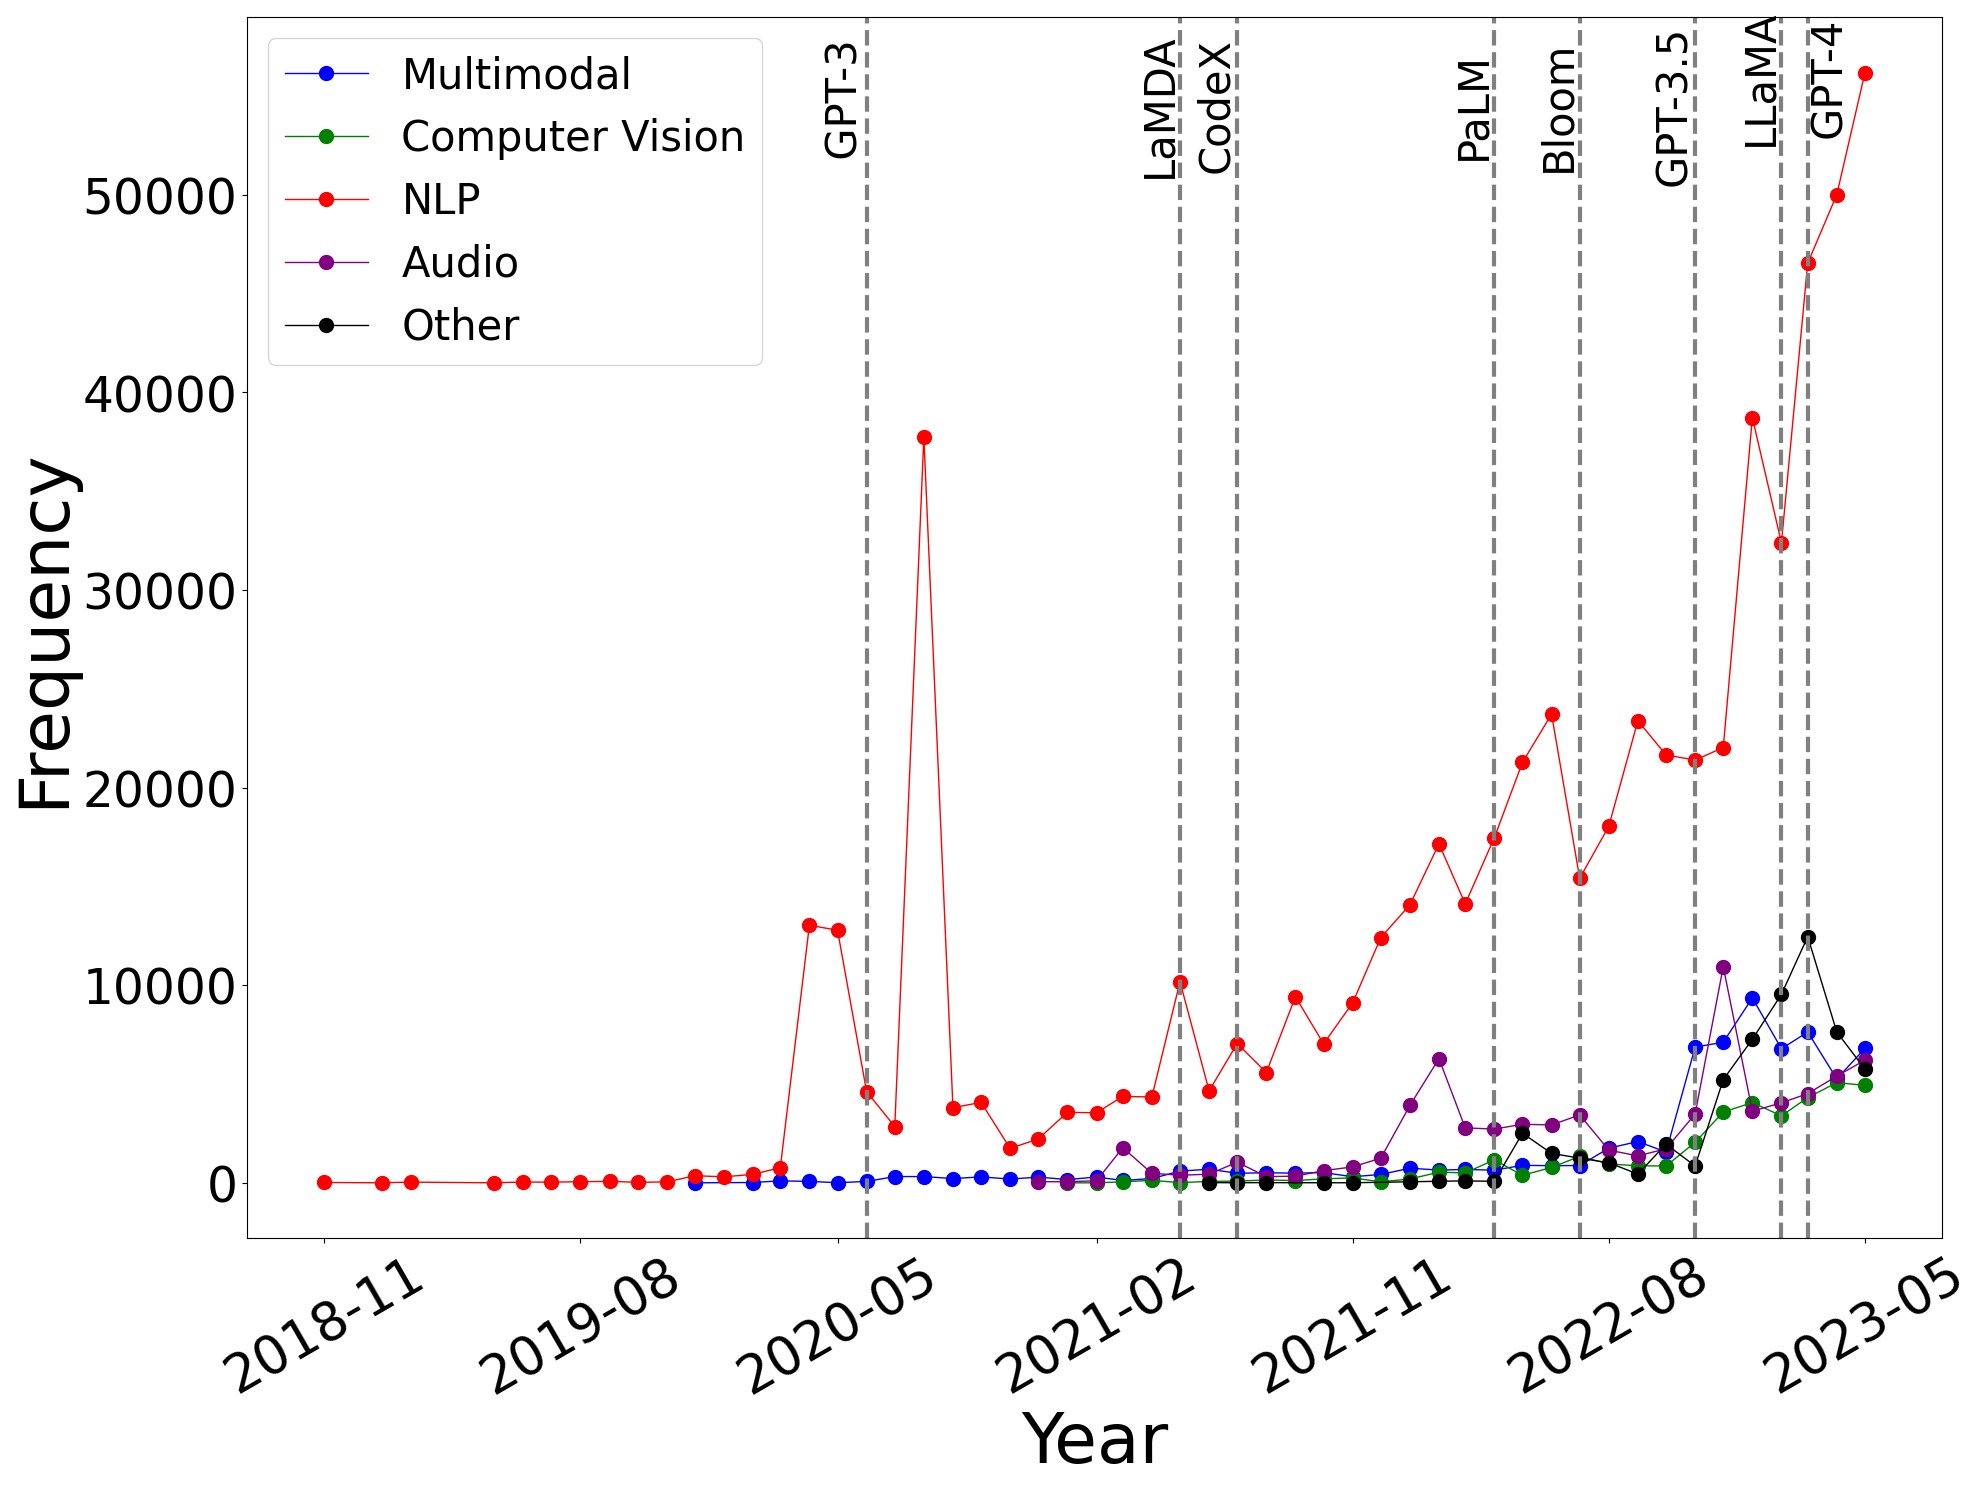

In [7]:
fig, ax = plt.subplots(figsize=(20, 15))

# Define colors for the lines (same order as the categories)
colors = ['blue', 'green', 'red', 'purple', 'black']  # Adjust as per your categories

for (key, values), color in zip(sorted_data_dict.items(), colors):
    if values:
        dates = list(values.keys())
        freqs = list(values.values())

        # Plot line
        ax.plot(dates, freqs, marker='o', linewidth=1, alpha=1, label=key, color=color, markersize=10)

# Add a vertical line for milestones
gpt3_release_date = datetime.strptime('2020-06', '%Y-%m')
ax.axvline(gpt3_release_date, color='grey', linestyle='--', lw=3)
ax.text(gpt3_release_date, ax.get_ylim()[1]*0.95-1500, ' GPT-3', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

# t5_release_date = datetime.strptime('2019-10', '%Y-%m')
# ax.axvline(t5_release_date, color='grey', linestyle='--', lw=2)
# ax.text(t5_release_date, ax.get_ylim()[1]*0.95-500, ' T5', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

lambda_release_date = datetime.strptime('2021-05', '%Y-%m')
ax.axvline(lambda_release_date, color='grey', linestyle='--', lw=3)
ax.text(lambda_release_date, ax.get_ylim()[1]*0.95-1500, 'LaMDA', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

codex_release_date = datetime.strptime('2021-07', '%Y-%m')
ax.axvline(codex_release_date, color='grey', linestyle='--', lw=3)
ax.text(codex_release_date, ax.get_ylim()[1]*0.95-1500, 'CodeX', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)


# GPTJ_release_date = datetime.strptime('2021-06', '%Y-%m')
# ax.axvline(GPTJ_release_date, color='grey', linestyle='--', lw=2)
# ax.text(GPTJ_release_date, ax.get_ylim()[1]*0.95, 'GPT-J', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)


palm_release_date = datetime.strptime('2022-04', '%Y-%m')
ax.axvline(palm_release_date, color='grey', linestyle='--', lw=3)
ax.text(palm_release_date, ax.get_ylim()[1]*0.95-1500, 'PaLM', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

# lamda2_release_date = datetime.strptime('2022-05', '%Y-%m')
# ax.axvline(lamda2_release_date, color='grey', linestyle='--', lw=2)
# ax.text(lamda2_release_date, ax.get_ylim()[1]*0.95, 'LaMDA 2', horizontalalignment='left', verticalalignment='center', fontsize=30, color='black', rotation=90)



bloom_release_date = datetime.strptime('2022-07', '%Y-%m')
ax.axvline(bloom_release_date, color='grey', linestyle='--', lw=3)
ax.text(bloom_release_date, ax.get_ylim()[1]*0.95-1500, 'Bloom', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

GPT35_release_date = datetime.strptime('2022-11', '%Y-%m')
ax.axvline(GPT35_release_date, color='grey', linestyle='--', lw=3)
ax.text(GPT35_release_date, ax.get_ylim()[1]*0.95-1500, 'GPT-3.5', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

llama_release_date = datetime.strptime('2023-02', '%Y-%m')
ax.axvline(llama_release_date, color='grey', linestyle='--', lw=3)
ax.text(llama_release_date, ax.get_ylim()[1]*0.95-100, 'LLaMA', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

GPT4_release_date = datetime.strptime('2023-03', '%Y-%m')
ax.axvline(GPT4_release_date, color='grey', linestyle='--', lw=3)
ax.text(GPT4_release_date, ax.get_ylim()[1]*0.95-100, 'GPT-4', horizontalalignment='left', verticalalignment='center', fontsize=30, color='black', rotation=90)


# palm2_release_date = datetime.strptime('2023-05', '%Y-%m')
# ax.axvline(palm2_release_date, color='grey', linestyle='--', lw=2)
# ax.text(palm2_release_date, ax.get_ylim()[1]*0.95, 'PaLM2', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)

# llama2_release_date = datetime.strptime('2023-07', '%Y-%m')
# ax.axvline(llama2_release_date, color='grey', linestyle='--', lw=2)
# ax.text(llama2_release_date, ax.get_ylim()[1]*0.95, 'LLaMA 2', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))  # Adjust interval as needed
plt.xticks(rotation=30, fontsize=38)
plt.yticks(fontsize=35)

# Add legend and labels
plt.legend(fontsize=30)
plt.xlabel("Year", fontsize=50)
plt.ylabel("Frequency", fontsize=50)
# plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()

plt.savefig("fig10.pdf")

In [4]:
mapping = {'natural-language-processing': "NLP", "multimodal": "Multimodal", "audio": "Audio", "computer-vision": "Computer Vision", "reinforcement-learning": "Reinforcement Learning", "graph-machine-learning": "Multimodal", "robotics": "Reinforcement Learning", "tabular": "Other", "time-series": "Other"}


In [5]:
param_count = {url: {} for url in json_file}

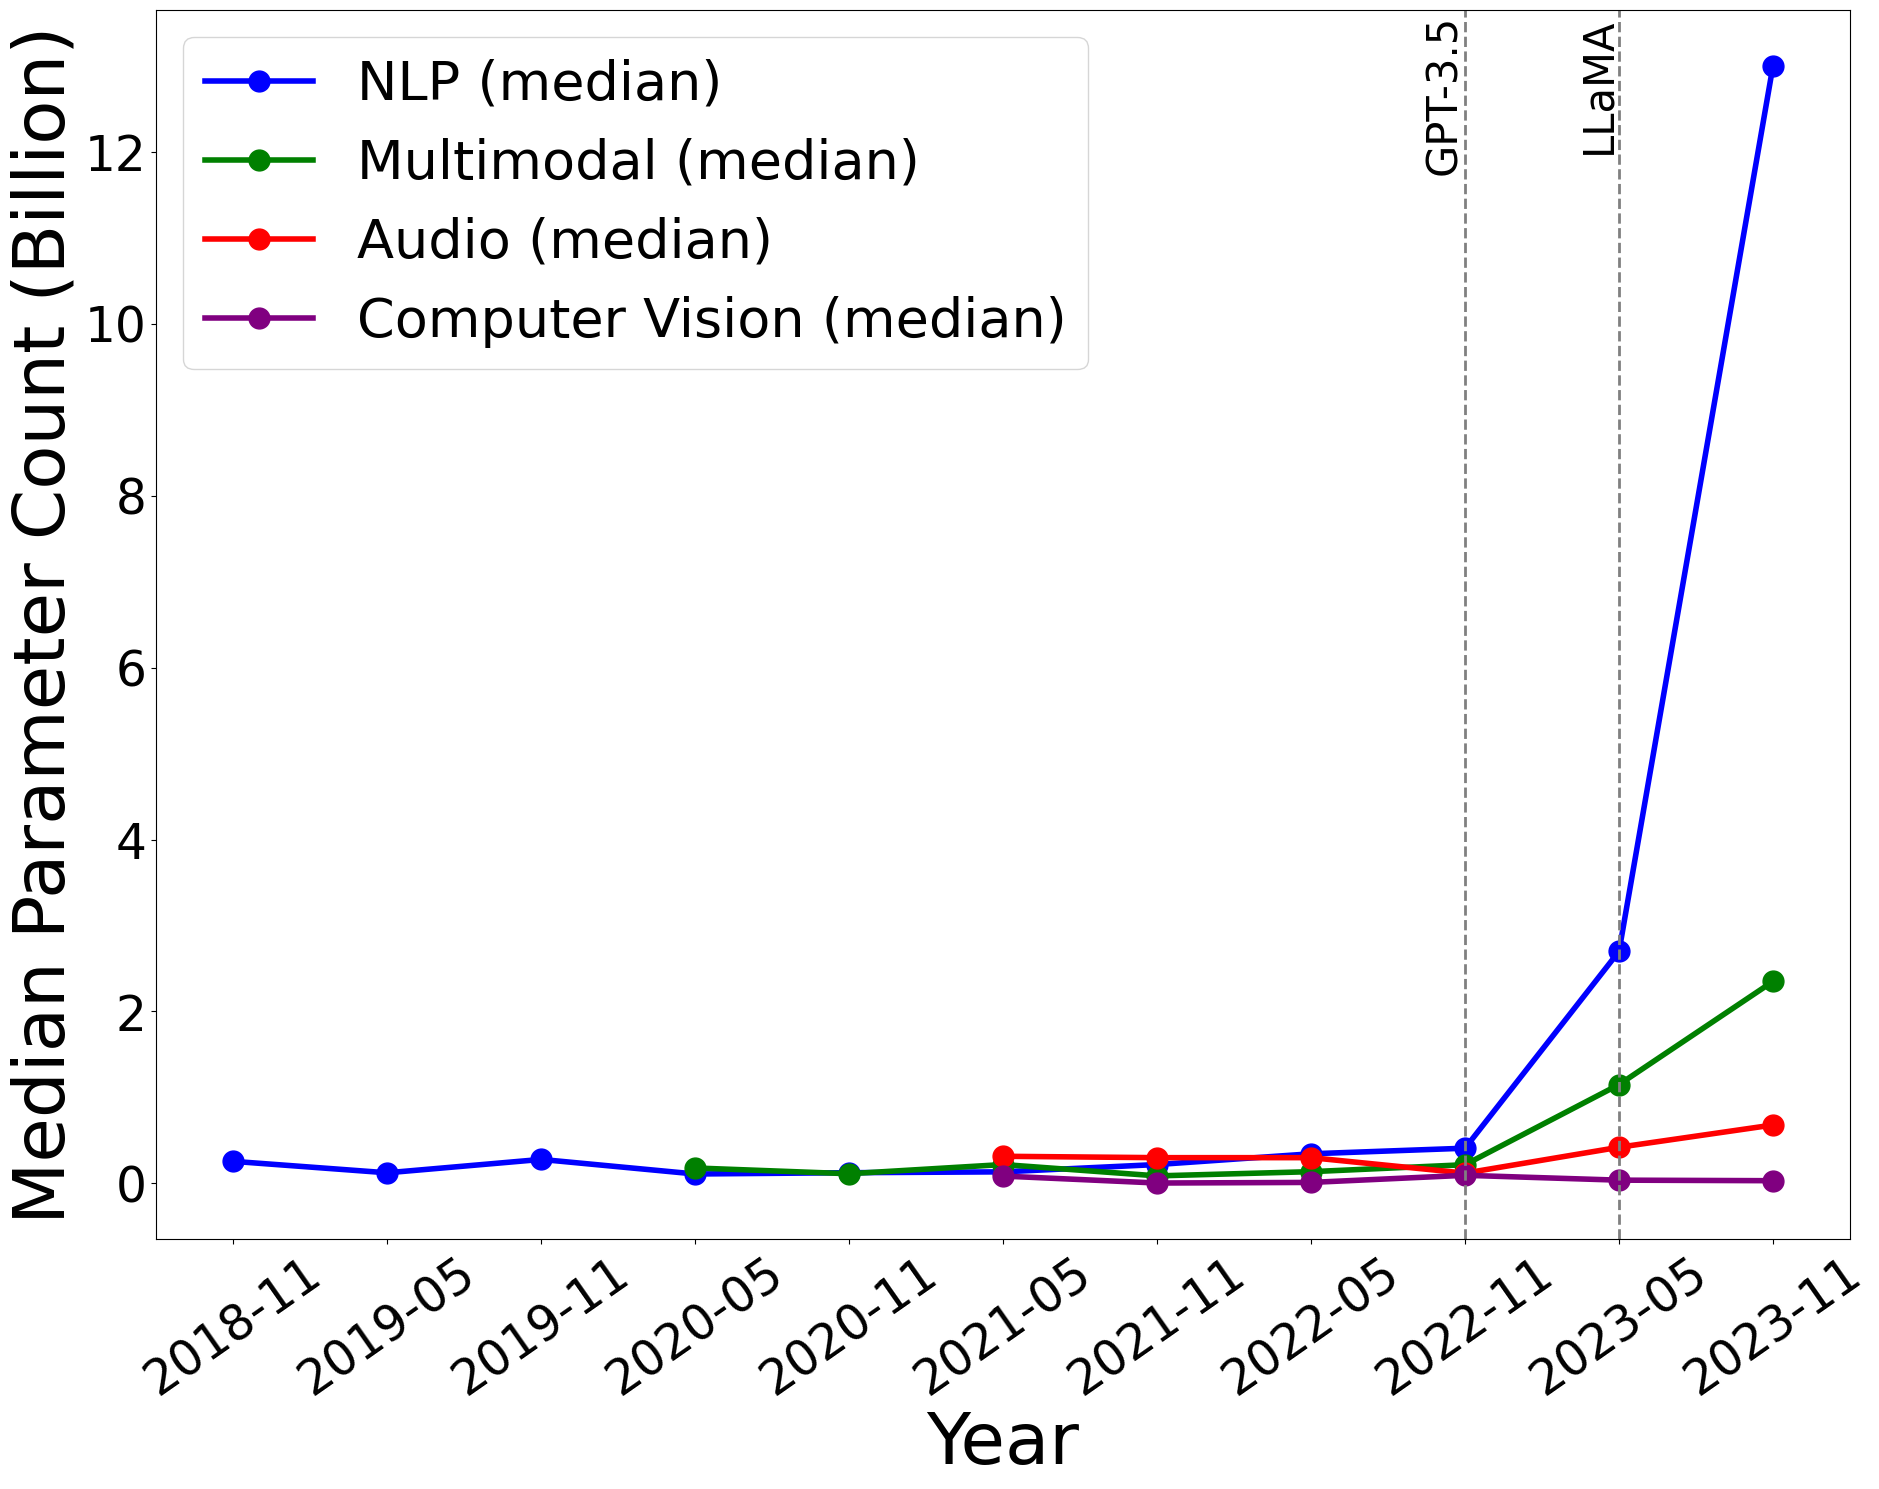

In [6]:
for model in json_file:
  if not type(json_file[model]) == str:
    if json_file[model]["domain"]:
      if type(json_file[model]["domain"]) == list: 
        adomain = json_file[model]["domain"][0]
      else:
        adomain = json_file[model]["domain"]
      if "," in adomain: 
        adomain = adomain.split(",")[0]
      
      param_count[model]["domain"] = mapping[adomain] 
      param_count[model]["params"] = ""
    else: 
      param_count[model]["domain"] = "Other"
      param_count[model]["params"] = ""

    for meta in json_file[model]: 
      if meta == "parameter_count": 
        param_count[model]['params'] = json_file[model][meta]

store = param_count.copy()


for model in param_count: 
  if not param_count[model]: 
    del store[model]

param_count = store


urls = [f'"https://huggingface.co/{x}"' for x in param_count.keys()]

query = f'''
      SELECT model.repo_url, hf_commit.created_at
      FROM model
      INNER JOIN hf_commit ON hf_commit.model_id = model.id
      WHERE model.repo_url IN ({','.join(urls)})
  '''
rows = queryit(cursor, query)



for row in rows: 
  url = row[0].replace('https://huggingface.co/', '')
  param_count[url]['date'] = row[1]


data_list = [[model_name] + list(details.values()) for model_name, details in param_count.items()]

df = pd.DataFrame(data_list, columns=['name', 'domain', 'params', 'date'])

df = df[df.params != '']

df = df.dropna()

def mil_bil(x):
  try:  
    if 'M' in x: 
      return 1000000 * float(re.sub('(M)', '', x))
    elif 'B' in x: 
      return 1000000000 * float(re.sub('(B)', '', x)) 
    else: 
      return 0
  except ValueError: 
    return 0 

df.params = df.params.apply(lambda x: mil_bil(x))


df = df[df.params != 0]

df.date = pd.to_datetime(df.date)


df.sort_values(by=['date'], inplace=True)


df.dropna(inplace=True)


domain_params_dict = {domain: list(group['params']) for domain, group in df.groupby('domain')}
domain_date_dict = {domain: list(group['date']) for domain, group in df.groupby('domain')}


def remove_outliers(data):
    # Calculate Q1, Q3 and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers and return the result
    return [x for x in data if lower_bound <= x <= upper_bound]

pd.plotting.register_matplotlib_converters()

def to_9month_interval(date):
    year, month = date.year, date.month
    if month <= 9:  # From January to September
        return f"{year}-01 to {year}-09"
    else:  # From October to June of the next year
        return f"{year}-10 to {year + 1}-06"
df['9_month_interval'] = df['date'].apply(to_9month_interval)

# Convert 'date' to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group data by 6-month intervals
# Note: 'QS' stands for quarter start frequency, which aligns with 6-month intervals in this context
grouped_median = df.groupby(['domain', pd.Grouper(key='date', freq='6M')])['params'].median().reset_index()

# Formatting the date for plotting
grouped_median['formatted_date'] = grouped_median['date'].dt.strftime('%Y-%m')
all_dates = grouped_median['formatted_date'].unique()
# Get unique domains
domains = df['domain'].unique()

# Create figure and axes
fig, ax = plt.subplots(figsize=(19, 15))

# Colors for different domains (adjust as per the number of domains)
colors = ['blue', 'green', 'red', 'purple']

# # Plotting the median values for each domain in 6-month intervals
for domain, color in zip(domains, colors):
    domain_data = grouped_median[grouped_median['domain'] == domain]
    ax.plot(domain_data['formatted_date'].astype(str), domain_data['params']/1000000000, marker='o', markersize=15, color=color, label=f'{domain} (median)', linewidth=4)


# Format x-axis for better date representation
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
ax.set_xticks(all_dates)
ax.tick_params(axis='x', rotation=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.legend(fontsize=39)
ax.set_xlabel('Year', fontsize = 52)
ax.set_ylabel('Median Parameter Count (Billion)', fontsize = 52)
# ax.grid(True)

ax.axvline('2022-11', color='gray', linestyle='--', linewidth=2) 
ax.text("2022-11", ax.get_ylim()[1]*0.95-0.3, 'GPT-3.5', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)


ax.axvline('2023-05', color='gray', linestyle='--', linewidth=2) 
ax.text("2023-05", ax.get_ylim()[1]*0.95-0.2, 'LLaMA', horizontalalignment='right', verticalalignment='center', fontsize=30, color='black', rotation=90)


# Show plot
plt.tight_layout()
plt.savefig("fig11.pdf")